In [1]:
import os
import h5py

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import iqr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from matplotlib.colors import LogNorm, SymLogNorm

import geom

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18)


In [2]:
crun = 291
modules = [3, 4, 14, 15]
basedir = "../data"

In [3]:
geom_fname = os.path.join(basedir, "agipd_taw9_oy2_1050addu_hmg5.geom")

geom_xy = geom.pixel_maps_from_geometry_file(geom_fname)

geom_x = (geom_xy[0] - 33).reshape(16, 512, 128)
geom_y = (geom_xy[1] - 36).reshape(16, 512, 128)
width = 50
geom_map = np.sqrt(geom_x * geom_x + geom_y * geom_y) < 160


In [4]:
noise = np.zeros([16, 512, 128], dtype=float)
badpx = np.ones([16, 512, 128], dtype=bool)
gain = np.zeros([16, 512, 128], dtype=float)
sig, val = [], []
for c in range(30):
    for m in modules:
        f=h5py.File(os.path.join(basedir, "calib/r{:04d}/final-AGIPD{:02d}-calib.h5".format(crun, m)), "r")
        noise[m,:,:] = f["Noise"][0,0]
        badpx[m,:,:] = f["Badpixel"][0,0]
        gain[m,:,:] = f["ADU_per_Photon"][0] / f["RelativeGain"][0,0]
        f.close()

    msk = np.logical_and(geom_map, np.logical_not(badpx))
    sig.append(noise[msk])
    val.append(gain[msk])
    
sig = np.concatenate(sig)
val = np.concatenate(val)


snr:  7.0  0.14285714285714285


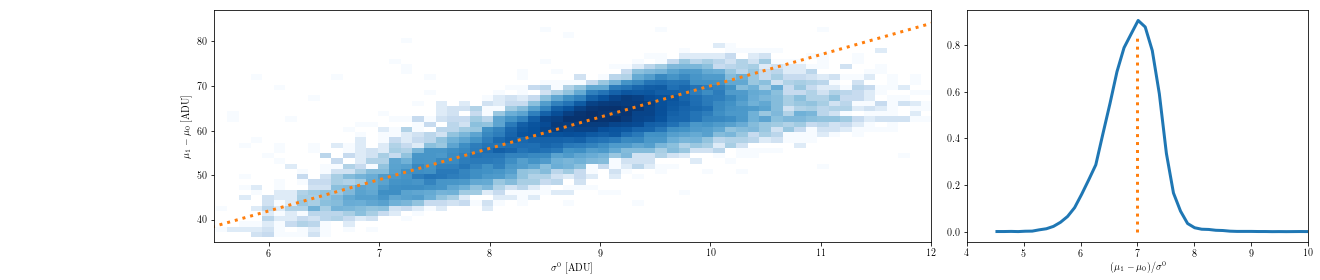

6.06993633161 7.54361679891 6.9229246566
6.59974760318 7.20408419293 6.9229246566
0.604336589754


In [5]:
r = 7

plt.figure(figsize=(16,4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

ax1.hist2d(sig,val, bins=(100,40), cmap=plt.cm.get_cmap('Blues'), norm=LogNorm())

r0, r1 = 5, 13
y0, y1 = r0*r, r1*r
ax1.plot([r0,r1], [y0, y1], 'C1:', linewidth=3)
ax1.set_xlim(5.5, 12)
ax1.set_ylim(35, 87)
ax1.set_ylabel("$\mu_1-\mu_0$ [ADU]",)
ax1.set_xlabel("$\sigma^0$ [ADU]")
print('snr: ',(y1-y0)/(r1-r0), "", 1/r)

h, x = np.histogram(val/sig, 80, density=True)
ax2.plot(0.5*(x[1:]+x[:-1]), h, lw=3)
y = np.interp(r, 0.5*(x[1:]+x[:-1]),h)
ax2.plot([r, r], [0., .85], ':', lw=3)
ax2.set_xlabel("$(\mu_1-\mu_0) / \sigma^0$")
ax2.set_xlim(4, 10)

plt.tight_layout()
plt.savefig('fig_det_1.png', dpi=300)
plt.show()

print(np.percentile(val/sig,5),np.percentile(val/sig,95), np.median(val/sig))
print(np.percentile(val/sig,25),np.percentile(val/sig,75), np.median(val/sig))
print(np.percentile(val/sig,75)-np.percentile(val/sig,25))